In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.3 MB/s eta 0:00:00


In [2]:
%%capture
!pip install transformers
!pip install datasets

In [4]:
import pandas as pd
import numpy as np
from transformers import AutoModelForQuestionAnswering, AutoTokenizer,TrainingArguments, Trainer
import seaborn as sns
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')

In [5]:
max_length = 384 # The maximum length of the feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.
batch_size = 16

In [9]:
df=pd.read_csv("/content/drive/MyDrive/qa_data.csv")
df=df.drop(columns=['Unnamed: 0'])
df=df.dropna()
df.head()

,context,question,id,answer_start,text
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,56be85543aeaaa14008c9063,269,in the late 1990s
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,56be85543aeaaa14008c9065,207,singing and dancing
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,56be85543aeaaa14008c9066,526,2003
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,56bf6b0f3aeaaa14008c9601,166,"Houston, Texas"
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,56bf6b0f3aeaaa14008c9602,276,late 1990s


In [10]:
df.context[0]

'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

In [11]:
model_name = "distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_name)
pad_on_right = tokenizer.padding_side == "right"

In [12]:
df['context_tokens'] = df['context'].apply(lambda x: len(tokenizer(x)['input_ids']))

Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors


<Axes: xlabel='context_tokens', ylabel='Count'>

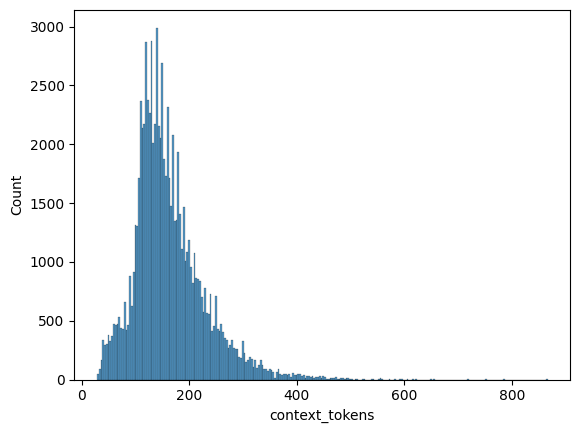

In [13]:
sns.histplot(df.context_tokens) # Max token size is 512 for BeRT 

In [15]:
#Making it into SquaD format for data seed forward
def convert_answers(r):
    start = r[0]
    text = r[1]
    return {
        'answer_start': [start],
        'text': [text]
    }
df = df.sample(frac=1, random_state=42)
df['answers'] = df[['answer_start', 'text']].apply(convert_answers, axis=1)
df.head()

,context,question,id,answer_start,text,context_tokens,answers
29025,From the early 1930s eight countries developed...,How many different countries developed radar s...,570d3f2ffed7b91900d45d95,21,eight,118,"{'answer_start': [21], 'text': ['eight']}"
36567,Clay models of ducks found in China dating bac...,How long have ducks possibly been in domestica...,572644e91125e71900ae1942,0,Clay models of ducks found in China dating bac...,172,"{'answer_start': [0], 'text': ['Clay models of..."
50768,The city also has several major surface arteri...,What western road provides access from New Hav...,5727dee74b864d1900163ef2,747,Route 34,225,"{'answer_start': [747], 'text': ['Route 34']}"
50841,New Haven was the location of one of Jim Morri...,A popular 70s rock band group once played in N...,572bcf17be1ee31400cb8499,37,Jim Morrison,130,"{'answer_start': [37], 'text': ['Jim Morrison']}"
72807,A database management system (DBMS) is a compu...,What is the purpose of a DBMS?,572f59fc947a6a140053c8a5,209,"to allow the definition, creation, querying, u...",205,"{'answer_start': [209], 'text': ['to allow the..."


In [16]:
df_train=df[:40000].reset_index(drop=True)
df_val=df[84000:].reset_index(drop=True)

In [17]:
train_dataset = Dataset.from_pandas(df_train)
valid_dataset = Dataset.from_pandas(df_val)

In [18]:
train_dataset[0]

{'context': 'From the early 1930s eight countries developed radar, these developments were sufficiently advanced by the late 1930s for development work on sound locating acoustic devices to be generally halted, although equipment was retained. Furthermore, in Britain the volunteer Observer Corps formed in 1925 provided a network of observation posts to report hostile aircraft flying over Britain. Initially radar was used for airspace surveillance to detect approaching hostile aircraft. However, the German Würzburg radar was capable of providing data suitable for controlling AA guns and the British AA No 1 Mk 1 GL radar was designed to be used on AA gun positions.',
 'question': 'How many different countries developed radar starting in the 1930s?',
 'id': '570d3f2ffed7b91900d45d95',
 'answer_start': 21,
 'text': 'eight',
 'context_tokens': 118,
 'answers': {'answer_start': [21], 'text': ['eight']}}

In [19]:
def prepare_train_features(examples):
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples.pop("offset_mapping")

    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        sequence_ids = tokenized_examples.sequence_ids(i)

        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
          
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples


In [20]:
tokenized_train_ds = train_dataset.map(prepare_train_features, batched=True, remove_columns=train_dataset.column_names)
tokenized_valid_ds = valid_dataset.map(prepare_train_features, batched=True, remove_columns=train_dataset.column_names)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2820 [00:00<?, ? examples/s]

In [21]:
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

In [25]:
args = TrainingArguments(
    f"qa",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-5,
    warmup_ratio=0.1,
    gradient_accumulation_steps=8,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
)

In [26]:
from transformers import default_data_collator

data_collator = default_data_collator

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_valid_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

In [28]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [29]:
trainer.save_model("bert-trained")